In [1]:
from eda_import import *

In [2]:
with open('/projects/btl/zxue/tasrkleat-TCGA-results/firebrowse-data/bulk_rsem_TPM/rsem-genes.txt') as inf:
    RSEM_GENES = [_.strip() for _ in inf.readlines()]

In [3]:
df_trva = pd.read_pickle('./data/transformed-data/train_test_split_stratified_meta/80-20/train.pkl')

In [4]:
dises = list(sorted(['KICH', 'KIRC', 'KIRP']))

In [5]:
df_trva = df_trva.query('disease in {0}'.format(dises)).query('sstype == "tumour"')

In [6]:
df_trva[RSEM_GENES] = StandardScaler().fit_transform(df_trva[RSEM_GENES])

# transform to 2D space first

In [7]:
clf = LogisticRegression(C=1, penalty='l1', tol=1e-10)

In [8]:
clf.fit(df_trva[RSEM_GENES], df_trva['disease'])

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-10,
          verbose=0, warm_start=False)

In [9]:
df_coef = pd.DataFrame(clf.coef_, columns=RSEM_GENES).abs().sum()

In [10]:
fea_genes = df_coef[df_coef > 0].index.values

In [11]:
pca = PCA(n_components=2)
pca1, pca2 = pca.fit_transform(df_trva[fea_genes]).T

In [12]:
df_trva['pca1'] = pca1
df_trva['pca2'] = pca2

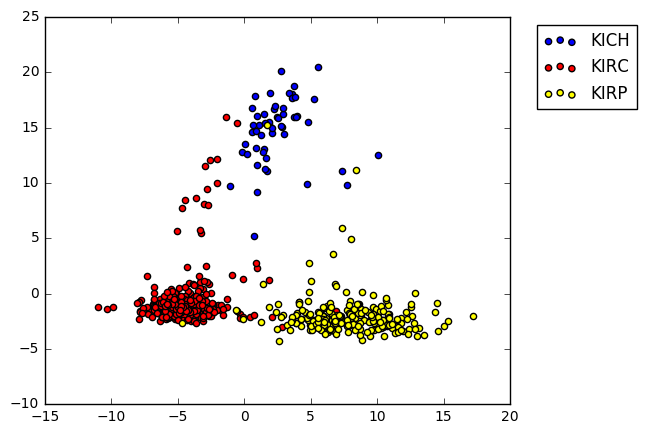

In [13]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

colors = ['blue', 'red', 'yellow']
for k, d in enumerate(dises):
    _df = df_trva.query('disease == "{0}"'.format(d))
    ax.scatter(_df.pca1.values, _df.pca2.values, c=colors[k], label=d)
    
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# OVR model

In [14]:
def get_line_coords(clf):
    w1, w2 = clf.coef_[0]
    b = clf.intercept_
    xs = np.arange(-20, 30)
    ys = (-b - w1 * xs) / w2
    return xs, ys

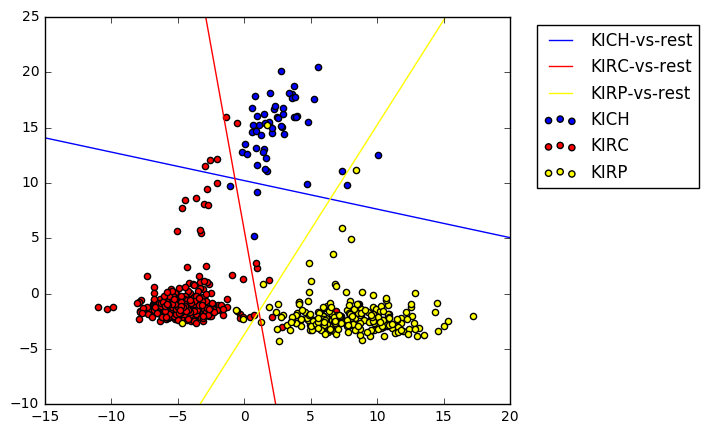

In [16]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

xlim = [-15, 20]
ylim = [-10, 25]

colors = ['blue', 'red', 'yellow']

ndf = df_trva[['pca1', 'pca2', 'disease']].copy()
for k, dise in enumerate(dises):
    _df = df_trva.query('disease == "{0}"'.format(dise))
    ax.scatter(_df.pca1.values, _df.pca2.values, c=colors[k], label=dise)
    
    # plot trained decision boundries
    ndf['label'] = ndf.disease.apply(lambda v: dise if v == dise else 'rest')
    nclf = LogisticRegression().fit(ndf[['pca1', 'pca2']], ndf['label'])
    lxs, lys = get_line_coords(nclf)
    ax.plot(lxs, lys, c=colors[k], label='{0}-vs-rest'.format(dise))
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Now demonstrate OVO

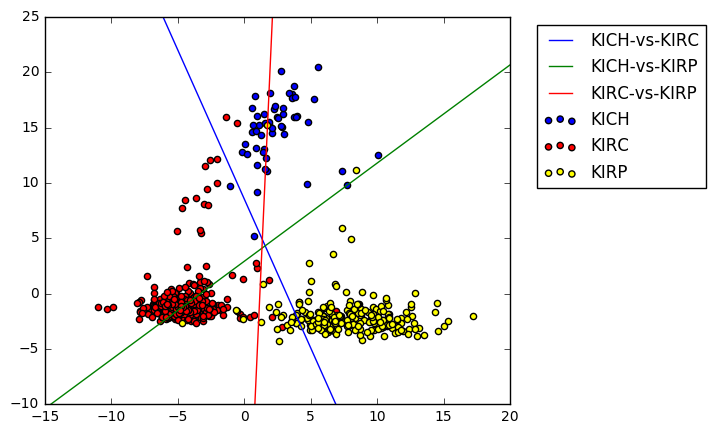

In [17]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)

xlim = [-15, 20]
ylim = [-10, 25]

colors = ['blue', 'red', 'yellow']
for k1, d1 in enumerate(dises):
    # scatter all classes
    _df = df_trva.query('disease == "{0}"'.format(d1))
    ax.scatter(_df.pca1.values, _df.pca2.values, c=colors[k1], label=d1)
    for k2, d2 in enumerate(dises):
        if d1 >= d2:
            continue

        # plot trained decision boundries
        _df = df_trva.query('disease in {0}'.format([d1, d2])).copy()
        _df['label'] = _df.disease.values
        _clf = LogisticRegression().fit(_df[['pca1', 'pca2']], _df['label'])
        lxs, lys = get_line_coords(_clf)
        ax.plot(lxs, lys, label='{0}-vs-{1}'.format(d1, d2))

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")